In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch


dataset = load_dataset("stefan-it/offenseval2020_tr")

# Define a function to preprocess the dataset (tokenize text and encode labels)
def preprocess_function(examples):
    # The label is at the beginning of each text, we'll extract it
    labels = [label.split("__label__")[1][:3] for label in examples['text']]  # assuming the label is within the text
    texts = [text.split("__label__")[1][4:] for text in examples['text']]  # Remove the label part from the text

    # Map the labels to integers (adjust according to your labels)
    label_map = {"NOT": 0, "OFF": 1}  # Modify as needed
    labels = [label_map[label] for label in labels]

    # Tokenize the text using the tokenizer
    encoding = tokenizer(texts,truncation=True, max_length=128)

    # Return the encoded text and labels
    return {**encoding, 'labels': torch.tensor(labels)}


tokenizer = AutoTokenizer.from_pretrained("dbmdz/distilbert-base-turkish-cased") # We will use turkish distilbert


encoded_dataset = dataset.map(preprocess_function, batched=True)


train_dataset = encoded_dataset["train"]
val_dataset = encoded_dataset["validation"]
test_dataset = encoded_dataset["test"]

print(train_dataset[0])  # Lets check the processed data

(array([24204.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5796.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

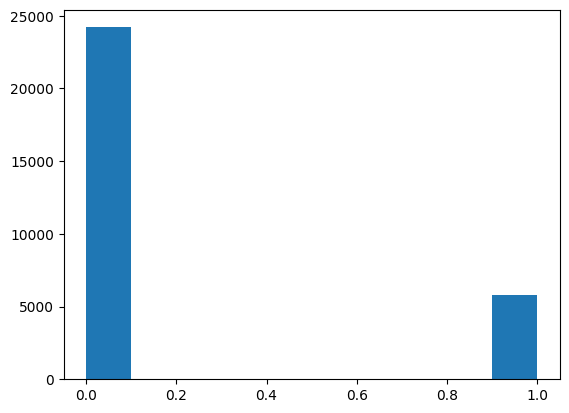

In [ ]:
import matplotlib.pyplot as plt
train_labels = [x for x in train_dataset['labels']]
test_labels = [x for x in test_dataset['labels']]
val_labels = [x for x in val_dataset['labels']]

plt.hist(train_labels) # As it can be seen the dataset is highly imbalanced

In [ ]:
from sklearn.metrics import accuracy_score, f1_score,balanced_accuracy_score
import numpy as np

# Default code gives only accuracy and loss values. To calculate other metrics we will define a compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    balanced_accuracy = balanced_accuracy_score(labels, preds) # weighted accuracy
    f1 = f1_score(labels, preds) # f1 score

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'f1': f1,
    }

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model_name = "dbmdz/distilbert-base-turkish-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=64,   
    per_device_eval_batch_size=64,    
    warmup_steps=500,               
    weight_decay=0.0001,              
    logging_dir='./logs',           
    eval_strategy="epoch",     
    save_strategy="epoch",          
    load_best_model_at_end=True,
    report_to="none", #don't write to wdb or tensorboard etc.
)


trainer = Trainer(
    model=model,                        
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,            
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/distilbert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2599171389.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1
1,No log,0.348910,0.854784,0.643357,0.442013
2,0.407000,0.313086,0.872437,0.728409,0.597122
3,0.255000,0.360337,0.867882,0.754111,0.622150


TrainOutput(global_step=1407, training_loss=0.2818217653709688, metrics={'train_runtime': 149.6196, 'train_samples_per_second': 601.525, 'train_steps_per_second': 9.404, 'total_flos': 1961266768832448.0, 'train_loss': 0.2818217653709688, 'epoch': 3.0})

In [8]:
trainer.evaluate(train_dataset)

{'eval_loss': 0.16150911152362823,
 'eval_accuracy': 0.9412,
 'eval_balanced_accuracy': 0.8677711159765868,
 'eval_f1': 0.83096972019931,
 'eval_runtime': 17.3019,
 'eval_samples_per_second': 1733.911,
 'eval_steps_per_second': 27.107,
 'epoch': 3.0}

In [9]:
trainer.evaluate(val_dataset)

{'eval_loss': 0.3130861520767212,
 'eval_accuracy': 0.8724373576309795,
 'eval_balanced_accuracy': 0.7284086254161983,
 'eval_f1': 0.5971223021582733,
 'eval_runtime': 1.0569,
 'eval_samples_per_second': 1661.462,
 'eval_steps_per_second': 26.493,
 'epoch': 3.0}

In [10]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.30552980303764343,
 'eval_accuracy': 0.8778344671201814,
 'eval_balanced_accuracy': 0.7547174122078562,
 'eval_f1': 0.6452674897119342,
 'eval_runtime': 2.1939,
 'eval_samples_per_second': 1608.068,
 'eval_steps_per_second': 25.525,
 'epoch': 3.0}